<strong>Tomasz Kot 233 978</strong>

<strong>Zadanie 1</strong> 

<strong>Algorytm najbliższej średniej z uwzględnieniem odległości Euklidesowej i
Machalanobisa.</strong>

Wymagane importy

In [611]:
import enum
from sklearn.utils import check_array
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Zaimportujmy wymagane dane

In [595]:
leaves = pd.read_csv("C:\\Users\\kotto\\OneDrive\\Pulpit\\smpd\\leaf.csv", header=None)
# wybierz cechy 
leaves_chosen = leaves[(leaves[0]==3)|(leaves[0]==5)|(leaves[0]==7)|(leaves[0]==8)|(leaves[0]==9)|(leaves[0]==10)]

leaves_chosen

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
22,3,1,0.70273,1.2099,0.36317,0.92110,0.98772,0.60555,0.023597,0.101340,0.089301,0.200880,0.038786,0.015895,0.000405,1.53710
23,3,2,0.66307,1.2065,0.32559,0.94952,0.99649,0.75954,0.013388,0.032621,0.021815,0.097143,0.009348,0.004028,0.000036,0.53410
24,3,3,0.61289,1.0991,0.33117,0.92405,0.98421,0.61661,0.025545,0.118770,0.054687,0.160600,0.025145,0.011672,0.000121,1.10760
25,3,4,0.70668,1.2510,0.38111,0.94226,0.99825,0.69250,0.019432,0.068724,0.031587,0.115020,0.013056,0.005311,0.000086,0.72247
26,3,5,0.66889,1.1435,0.38460,0.90355,0.99649,0.60571,0.028329,0.146060,0.057506,0.159310,0.024752,0.010304,0.000185,1.13650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,10,9,0.46094,1.1366,0.22905,0.95565,0.97544,0.71234,0.038286,0.266780,0.117530,0.220410,0.046329,0.016554,0.000648,1.98660
104,10,10,0.54913,1.2769,0.31283,0.93889,0.99123,0.59330,0.041539,0.314040,0.151880,0.260500,0.063550,0.023790,0.000843,2.20300
105,10,11,0.32168,1.1127,0.27055,0.95426,0.99298,0.70006,0.054260,0.535840,0.109670,0.215070,0.044212,0.016252,0.000612,1.84520
106,10,12,0.38564,1.0471,0.23328,0.95176,0.97368,0.67107,0.050832,0.470280,0.135630,0.247440,0.057693,0.022000,0.000868,1.97570


Wyznaczmy zbiory treningowe oraz testowe

In [596]:
test_size = 0.7
training_set, test_set, training_labels, test_labels = train_test_split(leaves_chosen.copy()[[4,7,8,9,12]], leaves_chosen.copy()[[0]], test_size=test_size, stratify=leaves_chosen.copy()[[0]])

Normalizacja danych

In [597]:
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)
training_labels, test_labels = training_labels.to_numpy(), test_labels.to_numpy()

In [598]:
class DistanceType(enum.Enum):
   Euclidean = 1
   Mahalanobis = 2 

In [599]:
def compute_mahalanobis(x, mean_vector, covariance_matrix):
    return np.sum(np.sum((np.expand_dims((np.tile(x,(np.shape(mean_vector)[0],1)) - mean_vector),axis=1))*np.linalg.inv(covariance_matrix), axis=2)*(np.tile(x,(np.shape(mean_vector)[0],1)) - mean_vector),axis=1)

In [600]:
def compute_euclidean(x, mean_vector, covariance_matrix):
    return np.sum((np.tile(x,(np.shape(mean_vector)[0],1)) - mean_vector) ** 2, axis=1) 

In [601]:
def nm_train(training_set, training_labels):    
    unique_labels = np.unique(training_labels)
    mean_vector = np.zeros((np.size(unique_labels), np.shape(training_set)[1]))
    covariance_matrix = np.zeros((np.size(unique_labels), np.shape(training_set)[1], np.shape(training_set)[1]))
    for idx, i in np.ndenumerate(unique_labels):
        indices = [j for j, x in enumerate(training_labels) if x == i]
        mean_vector[idx[0]] = np.mean(np.array(training_set)[indices], axis=0)
        covariance_matrix[idx[0]] = np.cov(np.array(training_set)[indices], ddof=0, rowvar=False)
    
    return mean_vector, covariance_matrix

In [602]:
def classify(x, mean_vector, covariance_matrix, distance_type):
    if distance_type == DistanceType.Mahalanobis: 
        distances = np.sum(np.sum((np.expand_dims((np.tile(x,(np.shape(mean_vector)[0],1)) - mean_vector),axis=1))*np.linalg.inv(covariance_matrix), axis=2)*(np.tile(x,(np.shape(mean_vector)[0],1)) - mean_vector), axis=1)
    else: 
        distances = compute_euclidean(x, mean_vector,covariance_matrix)
    result_indice = np.argmin(distances).astype(int)
    return np.unique(training_labels)[result_indice]
        

In [603]:
def nm_predict(training_set, training_labels, test_set, distance_type=DistanceType.Euclidean):
    # train the classifier
    mean_vector, covariance_matrix = nm_train(training_set, training_labels)
    # now we can classify
    test_set = check_array(test_set, accept_sparse='csr')
    y = np.array([])
    for x in test_set:
        y = np.append(y, classify(x, mean_vector, covariance_matrix, distance_type))
    
    return y

<strong>Zadanie 2</strong>

Ocenić oba podejścia i wyświetlić tablicę pomyłek

In [636]:
predicted_euclidean = nm_predict(training_set, training_labels, test_set)
predicted_mahalanobis = nm_predict(training_set, training_labels, test_set, DistanceType.Mahalanobis)
print('Predicted using Euclidean distance')
print(predicted_euclidean)
print('Predicted using Mahalanobis distance')
print(predicted_mahalanobis)

Predicted using Euclidean distance
[ 8.  5.  5.  8.  7. 10.  3.  9.  5. 10. 10.  5. 10.  7.  9.  7. 10.  5.
 10.  5.  5.  3.  7.  3.  5.  7. 10.  7.  3.  7.  9.  9.  3.  8.  8.  5.
  8.  5.  8. 10.  3.  9.  7.  5. 10.  5.  8.  7.  9.]
Predicted using Mahalanobis distance
[8. 3. 5. 8. 8. 3. 8. 8. 8. 8. 8. 5. 8. 8. 8. 8. 8. 8. 8. 7. 7. 8. 8. 8.
 5. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 7. 8. 8. 8. 8. 8. 8. 8. 5. 8. 8.
 8.]


<strong>Confussion matrixes dla klasyfikatorów</strong>

In [637]:
def draw_confusion_matrix(predicted_labels):
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.ylabel('Prawdziwa', fontsize=20)
    plt.xlabel('Przewidziana', fontsize=20)
    for i in range(np.shape(cm)[0]):
            for j in range(np.shape(cm)[0]):
                plt.text(j, i, str(cm[i][j]), fontsize=20, verticalalignment='center', horizontalalignment='center')
    plt.show()

<strong>Odległość Euklidesa</strong>

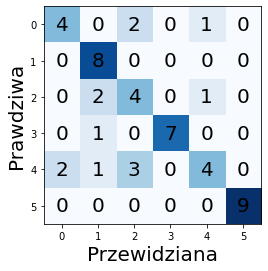

In [638]:
draw_confusion_matrix(predicted_euclidean)

<strong>Odległość Mahalanobisa</strong>

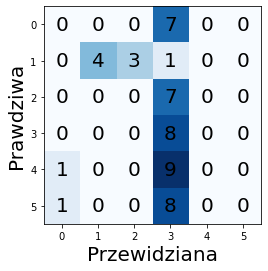

In [641]:
draw_confusion_matrix(predicted_mahalanobis)

<strong>Wnioski</strong>

Z racji, że w tablicy pomyłek wszystkie poprawne predykcje (wyniki) są położone na głównej diagonalnej. Po wygenerowanych macierzach pomyłek można stwierdzić, że zastosowanie odległości Euklidesa daje lepsze rezultaty niż odległości Mahalanobisa. Odległość Mahalanobisa ma zastosowanie w regresji liniowej. Warto zauważyć, że w tym przypadku jej zastosowanie generuje bardziej równomiernie rozłożone wyniki, które jedynie w części pokrywają się z główna diagonalną.

<strong>Zadanie 3</strong>

Porównać NM z kNN z poprzedniego laboratorium i wyświetlić tablicę pomyłek

<strong>Kod klasyfikatorna kNN</strong>

In [633]:
def kNN_classify(X, training_set, training_labels, k):
        distances = np.sum((np.tile(X,(np.shape(training_set)[0],1)) - training_set)**2, axis=1)
        knn_indices = np.argsort(distances)[:k].astype(int)
        nearest_neighbours = np.array(training_labels)[knn_indices]
        return max(set(nearest_neighbours[:,0]), key=list(nearest_neighbours[:,0]).count)
    
def kNN_predict(k, training_set, training_labels, test_set):
    X = check_array(test_set, accept_sparse='csr')
    y = np.array([])
    for x in test_set:
        y = np.append(y, kNN_classify(x, training_set, training_labels, k))
    return y

Dokonajmy klasyfikacji przy pomocy tego klasyfikatora

In [634]:
predicted_kNN = kNN_predict(3, training_set, training_labels, test_set)

print('Przewidziane przez kNN')
print(predicted_kNN)

Przewidziane przez kNN
[ 8.  9.  5.  8.  9.  9.  3.  9.  5. 10. 10.  5. 10.  7.  9.  7. 10.  5.
 10.  5.  5.  3.  9.  3.  5.  9. 10.  7.  3.  7.  5.  3.  3.  8.  8.  5.
  8.  5.  8. 10.  3.  9.  7.  5. 10.  5.  8.  7.  3.]


<strong>Narysujmy tablicę pomyłek dla NM oraz kNN</strong>

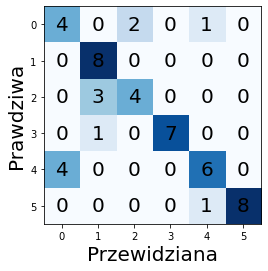

In [635]:
draw_confusion_matrix(predicted_kNN)

<strong>Wnioski</strong>

Klasyfikator kNN daje nieco dokładniejsze wyniki niż klasyfikator NM (przynajmniej jego wersja wykorzystująca odległość Euklidesa; więcej zakwalifikowanych punktów znajduje się na głównej diagonalnej). Z tego względu stosowanie kNN wydaje się być najlepszym wyborem jeśli chcemy uzyskać "bliskie rzeczywistym" wyniki. Mimo tego NM zabiera mniej zasobów w czasie obliczania i to jest główny powód jego stosowania, przy nieco gorszych wynikach.